# 4.6 Lab: Logistic Regression, LDA, QDA, and KNN

## 4.6.1 The Stock Market Data

In [163]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import math
from patsy import dmatrices


import statsmodels.discrete.discrete_model as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import *
from sklearn import datasets, linear_model
from sklearn.metrics import confusion_matrix

We will begin by examining some numerical and graphical summaries of
the Smarket data. This data set consists of
percentage returns for the S&P 500 stock index over 1, 250 days, from the
beginning of 2001 until the end of 2005. For each date, we have recorded
the percentage returns for each of the five previous trading days, Lag1
through Lag5. We have also recorded Volume (the number of shares traded 
on the previous day, in billions), Today (the percentage return on the date
in question) and Direction (whether the market was Up or Down on this
date).

In [164]:
Smarket = pd.read_csv('data/Smarket.csv', header=0)

In [165]:
Smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [166]:
Smarket.tail()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down
1249,2005,-0.298,0.130,-0.955,0.043,0.422,1.38254,-0.489,Down


In [167]:
Smarket.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.00000,1250.000000,1250.000000
mean,2003.016000,0.003834,0.003919,0.001716,0.001636,0.00561,1.478305,0.003138
std,1.409018,1.136299,1.136280,1.138703,1.138774,1.14755,0.360357,1.136334
min,2001.000000,-4.922000,-4.922000,-4.922000,-4.922000,-4.92200,0.356070,-4.922000
25%,2002.000000,-0.639500,-0.639500,-0.640000,-0.640000,-0.64000,1.257400,-0.639500
50%,2003.000000,0.039000,0.039000,0.038500,0.038500,0.03850,1.422950,0.038500
75%,2004.000000,0.596750,0.596750,0.596750,0.596750,0.59700,1.641675,0.596750
max,2005.000000,5.733000,5.733000,5.733000,5.733000,5.73300,3.152470,5.733000


In [168]:
Smarket.shape

(1250, 9)

### For panda data frame, there is a method corr to compute pairwise correlation between numerical variables
As one would expect, the correlations between the lag variables and today’s returns are close to zero.

In [169]:
Smarket.corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


In [170]:
Smarket.cov() # covariance

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.985332,0.047551,0.048986,0.053259,0.057264,0.048165,0.273680,0.048186
Lag1,0.047551,1.291175,-0.033950,-0.013979,-0.003864,-0.007399,0.016752,-0.033772
Lag2,0.048986,-0.033950,1.291133,-0.033507,-0.014044,-0.004639,-0.017764,-0.013235
Lag3,0.053259,-0.013979,-0.033507,1.296644,-0.031188,-0.024577,-0.017162,-0.003167
Lag4,0.057264,-0.003864,-0.014044,-0.031188,1.296806,-0.035393,-0.019868,-0.008928
Lag5,0.048165,-0.007399,-0.004639,-0.024577,-0.035393,1.316871,-0.009099,-0.045458
Volume,0.273680,0.016752,-0.017764,-0.017162,-0.019868,-0.009099,0.129857,0.005975
Today,0.048186,-0.033772,-0.013235,-0.003167,-0.008928,-0.045458,0.005975,1.291255


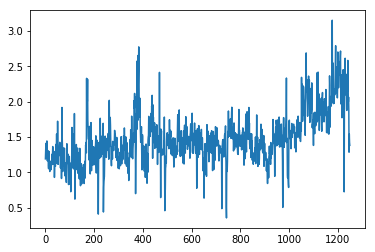

In [171]:
plt.plot(Smarket.iloc[:, 6])
# plt.plot(Smarket.ix[:, 6]) # behave like loc but falls back to behaving like iloc if the label is not in the index
# plt.plot(Smarket[['Volume']])
plt.show()

## 4.6.2 Logistic Regression

## Use Statsmodels.

patsy is a Python package for describing statistical models (especially linear models, or models that have a linear component) and building design matrices. It is closely inspired by and compatible with the formula mini-language used in R and S.
Generate design matrices suitable for regressing y onto X. The return value is a Python tuple containing two DesignMatrix objects, 
the first representing the left-hand side of our formula, and the second representing the right-hand side. Notice that an intercept term was automatically added to the right-hand side.

Help for dmatrices: http://patsy.readthedocs.io/en/latest/quickstart.html

Overview for dmatrices: http://patsy.readthedocs.io/en/latest/overview.html

In [172]:
y, X = dmatrices('Direction~Lag1+Lag2+Lag3+Lag4+Lag5+Volume', Smarket, return_type = 'dataframe')
print (y)

      Direction[Down]  Direction[Up]
0                 0.0            1.0
1                 0.0            1.0
2                 1.0            0.0
3                 0.0            1.0
4                 0.0            1.0
5                 0.0            1.0
6                 1.0            0.0
7                 0.0            1.0
8                 0.0            1.0
9                 0.0            1.0
10                1.0            0.0
11                1.0            0.0
12                0.0            1.0
13                0.0            1.0
14                1.0            0.0
15                0.0            1.0
16                1.0            0.0
17                0.0            1.0
18                1.0            0.0
19                1.0            0.0
20                1.0            0.0
21                1.0            0.0
22                0.0            1.0
23                1.0            0.0
24                1.0            0.0
25                0.0            1.0
2

In [173]:
print(X)

      Intercept   Lag1   Lag2   Lag3   Lag4   Lag5   Volume
0           1.0  0.381 -0.192 -2.624 -1.055  5.010  1.19130
1           1.0  0.959  0.381 -0.192 -2.624 -1.055  1.29650
2           1.0  1.032  0.959  0.381 -0.192 -2.624  1.41120
3           1.0 -0.623  1.032  0.959  0.381 -0.192  1.27600
4           1.0  0.614 -0.623  1.032  0.959  0.381  1.20570
5           1.0  0.213  0.614 -0.623  1.032  0.959  1.34910
6           1.0  1.392  0.213  0.614 -0.623  1.032  1.44500
7           1.0 -0.403  1.392  0.213  0.614 -0.623  1.40780
8           1.0  0.027 -0.403  1.392  0.213  0.614  1.16400
9           1.0  1.303  0.027 -0.403  1.392  0.213  1.23260
10          1.0  0.287  1.303  0.027 -0.403  1.392  1.30900
11          1.0 -0.498  0.287  1.303  0.027 -0.403  1.25800
12          1.0 -0.189 -0.498  0.287  1.303  0.027  1.09800
13          1.0  0.680 -0.189 -0.498  0.287  1.303  1.05310
14          1.0  0.701  0.680 -0.189 -0.498  0.287  1.14980
15          1.0 -0.562  0.701  0.680 -0.

In [174]:
print(type(y))
print(type(X))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


### Since we are more interested in stock marketing up, we take the second column of y as our response

In [175]:
logit = sm.Logit(y.iloc[:,1], X)  # y.iloc[:,1] is Direction[Up].
print(logit.fit().summary())  # Lag1 has the best P value

Optimization terminated successfully.
         Current function value: 0.691034
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:          Direction[Up]   No. Observations:                 1250
Model:                          Logit   Df Residuals:                     1243
Method:                           MLE   Df Model:                            6
Date:                Sun, 09 Sep 2018   Pseudo R-squ.:                0.002074
Time:                        17:53:25   Log-Likelihood:                -863.79
converged:                       True   LL-Null:                       -865.59
                                        LLR p-value:                    0.7319
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1260      0.241     -0.523      0.601      -0.598       0.346
Lag1          -0.0731      0.

### To extract the parameters directly

In [176]:
logit.fit().params

Optimization terminated successfully.
         Current function value: 0.691034
         Iterations 4


Intercept   -0.126000
Lag1        -0.073074
Lag2        -0.042301
Lag3         0.011085
Lag4         0.009359
Lag5         0.010313
Volume       0.135441
dtype: float64

### To extract the probability of the market going up

In [177]:
print(y.iloc[0:10,1]) # ground truth

0    1.0
1    1.0
2    0.0
3    1.0
4    1.0
5    1.0
6    0.0
7    1.0
8    1.0
9    1.0
Name: Direction[Up], dtype: float64


In [178]:
logit.fit().predict()

Optimization terminated successfully.
         Current function value: 0.691034
         Iterations 4


array([0.50708413, 0.48146788, 0.48113883, ..., 0.5392683 , 0.52611829,
       0.51791656])

In [179]:
logit.fit().predict()[0:10]

Optimization terminated successfully.
         Current function value: 0.691034
         Iterations 4


array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

### In order to make a prediction as to whether the market will go up or down on a particular day, we must convert these predicted probabilities into class labels, Up (1) or Down (0).

In [180]:
predict_label = pd.DataFrame(np.zeros(shape=(1250,1)), columns = ['label'])

In [181]:
print(predict_label) # dataframe type

      label
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
5       0.0
6       0.0
7       0.0
8       0.0
9       0.0
10      0.0
11      0.0
12      0.0
13      0.0
14      0.0
15      0.0
16      0.0
17      0.0
18      0.0
19      0.0
20      0.0
21      0.0
22      0.0
23      0.0
24      0.0
25      0.0
26      0.0
27      0.0
28      0.0
29      0.0
...     ...
1220    0.0
1221    0.0
1222    0.0
1223    0.0
1224    0.0
1225    0.0
1226    0.0
1227    0.0
1228    0.0
1229    0.0
1230    0.0
1231    0.0
1232    0.0
1233    0.0
1234    0.0
1235    0.0
1236    0.0
1237    0.0
1238    0.0
1239    0.0
1240    0.0
1241    0.0
1242    0.0
1243    0.0
1244    0.0
1245    0.0
1246    0.0
1247    0.0
1248    0.0
1249    0.0

[1250 rows x 1 columns]


In [182]:
logit.fit().predict()>0.5

Optimization terminated successfully.
         Current function value: 0.691034
         Iterations 4


array([ True, False, False, ...,  True,  True,  True])

In [183]:
predict_label.iloc[logit.fit().predict()>0.5] = 1

Optimization terminated successfully.
         Current function value: 0.691034
         Iterations 4


In [184]:
print(predict_label)

      label
0       1.0
1       0.0
2       0.0
3       1.0
4       1.0
5       1.0
6       0.0
7       1.0
8       1.0
9       0.0
10      0.0
11      1.0
12      1.0
13      0.0
14      0.0
15      1.0
16      1.0
17      1.0
18      1.0
19      0.0
20      1.0
21      1.0
22      1.0
23      0.0
24      1.0
25      1.0
26      0.0
27      1.0
28      1.0
29      1.0
...     ...
1220    1.0
1221    1.0
1222    1.0
1223    1.0
1224    1.0
1225    1.0
1226    0.0
1227    1.0
1228    1.0
1229    1.0
1230    1.0
1231    1.0
1232    1.0
1233    1.0
1234    1.0
1235    1.0
1236    1.0
1237    1.0
1238    1.0
1239    1.0
1240    1.0
1241    1.0
1242    1.0
1243    1.0
1244    1.0
1245    1.0
1246    1.0
1247    1.0
1248    1.0
1249    1.0

[1250 rows x 1 columns]


### We can evalue the TRAINING result by constructing a confusion matrix 

In [185]:
confusion_matrix(y.iloc[:,1], predict_label.iloc[:,0])

array([[145, 457],
       [141, 507]], dtype=int64)

In [186]:
y_actu = pd.Series(y.iloc[:,1], name='Actual')
y_pred = pd.Series(predict_label.iloc[:,0], name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print(df_confusion)

Predicted  0.0  1.0
Actual             
0.0        145  457
1.0        141  507


### The diagonal elements of the confusion matrix indicate correct predictions, while the off-diagonals represent incorrect predictions. In this case, logistic regression correctly predicted the movement of the market 52.2% of the time.

In [187]:
np.mean(y.iloc[:,1] == predict_label.iloc[:,0]) # to get accuracy

0.5216

### In order to better assess the accuracy of the logistic regression model in this setting, we can fit the model using part of the data, and then examine how well it predicts the held out data. This will yield a more realistic error rate, in the sense that in practice we will be interested in our model’s performance not on the data that we used to fit the model, but rather on days in the future for which the market’s movements are unknown.

In [188]:
Smarket_2005 = Smarket.query('Year >= 2005') # Smarket_2005 = Smarket[Smarket.Year >= 2005]
Smarket_train = Smarket.query('Year < 2005') # Smarket_train = Smarket[Smarket.Year < 2005]

In [189]:
print(Smarket_2005)

      Year   Lag1   Lag2   Lag3   Lag4   Lag5   Volume  Today Direction
998   2005 -0.134  0.008 -0.007  0.715 -0.431  0.78690 -0.812      Down
999   2005 -0.812 -0.134  0.008 -0.007  0.715  1.51080 -1.167      Down
1000  2005 -1.167 -0.812 -0.134  0.008 -0.007  1.72100 -0.363      Down
1001  2005 -0.363 -1.167 -0.812 -0.134  0.008  1.73890  0.351        Up
1002  2005  0.351 -0.363 -1.167 -0.812 -0.134  1.56910 -0.143      Down
1003  2005 -0.143  0.351 -0.363 -1.167 -0.812  1.47790  0.342        Up
1004  2005  0.342 -0.143  0.351 -0.363 -1.167  1.49040 -0.610      Down
1005  2005 -0.610  0.342 -0.143  0.351 -0.363  1.48880  0.398        Up
1006  2005  0.398 -0.610  0.342 -0.143  0.351  1.56210 -0.863      Down
1007  2005 -0.863  0.398 -0.610  0.342 -0.143  1.51030  0.600        Up
1008  2005  0.600 -0.863  0.398 -0.610  0.342  1.33540  0.967        Up
1009  2005  0.967  0.600 -0.863  0.398 -0.610  1.59680 -0.949      Down
1010  2005 -0.949  0.967  0.600 -0.863  0.398  1.49870 -0.778   

In [190]:
print(Smarket_train)

     Year   Lag1   Lag2   Lag3   Lag4   Lag5   Volume  Today Direction
0    2001  0.381 -0.192 -2.624 -1.055  5.010  1.19130  0.959        Up
1    2001  0.959  0.381 -0.192 -2.624 -1.055  1.29650  1.032        Up
2    2001  1.032  0.959  0.381 -0.192 -2.624  1.41120 -0.623      Down
3    2001 -0.623  1.032  0.959  0.381 -0.192  1.27600  0.614        Up
4    2001  0.614 -0.623  1.032  0.959  0.381  1.20570  0.213        Up
5    2001  0.213  0.614 -0.623  1.032  0.959  1.34910  1.392        Up
6    2001  1.392  0.213  0.614 -0.623  1.032  1.44500 -0.403      Down
7    2001 -0.403  1.392  0.213  0.614 -0.623  1.40780  0.027        Up
8    2001  0.027 -0.403  1.392  0.213  0.614  1.16400  1.303        Up
9    2001  1.303  0.027 -0.403  1.392  0.213  1.23260  0.287        Up
10   2001  0.287  1.303  0.027 -0.403  1.392  1.30900 -0.498      Down
11   2001 -0.498  0.287  1.303  0.027 -0.403  1.25800 -0.189      Down
12   2001 -0.189 -0.498  0.287  1.303  0.027  1.09800  0.680        Up
13   2

### We will use the training dataset to build the logistic regression model 

In [191]:
y_train, X_train = dmatrices('Direction~Lag1+Lag2+Lag3+Lag4+Lag5+Volume', Smarket_train, return_type = 'dataframe')
y_test, X_test = dmatrices('Direction~Lag1+Lag2+Lag3+Lag4+Lag5+Volume', Smarket_2005, return_type = 'dataframe')

In [192]:
logit = sm.Logit(y_train.iloc[:,1], X_train)
print (logit.fit().summary())

Optimization terminated successfully.
         Current function value: 0.691936
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:          Direction[Up]   No. Observations:                  998
Model:                          Logit   Df Residuals:                      991
Method:                           MLE   Df Model:                            6
Date:                Sun, 09 Sep 2018   Pseudo R-squ.:                0.001562
Time:                        17:53:26   Log-Likelihood:                -690.55
converged:                       True   LL-Null:                       -691.63
                                        LLR p-value:                    0.9044
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1912      0.334      0.573      0.567      -0.463       0.845
Lag1          -0.0542      0.

In [193]:
X_test.shape

(252, 7)

In [194]:
type(y_test)

pandas.core.frame.DataFrame

In [195]:
preds = logit.fit().predict(X_test)
predict_label = pd.DataFrame(np.zeros(shape=(X_test.shape[0],1)), columns = ['label'])
threshold = 0.5
# predict_label.iloc[preds > threshold] = 1  # it will cause error
predict_label.iloc[preds.values > threshold] = 1  # use preds.values to avoid error
confusion_matrix(y_test.iloc[:,1], predict_label.iloc[:,0])

Optimization terminated successfully.
         Current function value: 0.691936
         Iterations 4


array([[77, 34],
       [97, 44]], dtype=int64)

In [196]:
type(preds.values)

numpy.ndarray

In [197]:
preds.values

array([0.52821955, 0.51566877, 0.52265215, 0.51385435, 0.49833448,
       0.50109124, 0.50277035, 0.50956797, 0.5040112 , 0.5106408 ,
       0.51011828, 0.48116529, 0.50529498, 0.52363164, 0.51683637,
       0.5125333 , 0.49821786, 0.48827676, 0.49601353, 0.50518787,
       0.49106893, 0.47897552, 0.49125768, 0.50562365, 0.48891002,
       0.49676599, 0.508446  , 0.51682505, 0.50731679, 0.48683967,
       0.50074673, 0.50097952, 0.50126923, 0.51237197, 0.51132798,
       0.51419056, 0.51202188, 0.48489254, 0.48048287, 0.49749512,
       0.50018783, 0.49561147, 0.49970797, 0.48837547, 0.48939833,
       0.50885903, 0.51952318, 0.50887292, 0.51091768, 0.50629379,
       0.50757365, 0.51889558, 0.50899076, 0.47500344, 0.501955  ,
       0.50686645, 0.49207937, 0.49566767, 0.49383793, 0.49170509,
       0.47713269, 0.46778418, 0.49536337, 0.49399758, 0.48150925,
       0.48687889, 0.48381536, 0.50481923, 0.51397161, 0.48196048,
       0.49583069, 0.50824735, 0.50249513, 0.49530876, 0.47078

In [198]:
type(preds)

pandas.core.series.Series

In [199]:
preds

998     0.528220
999     0.515669
1000    0.522652
1001    0.513854
1002    0.498334
1003    0.501091
1004    0.502770
1005    0.509568
1006    0.504011
1007    0.510641
1008    0.510118
1009    0.481165
1010    0.505295
1011    0.523632
1012    0.516836
1013    0.512533
1014    0.498218
1015    0.488277
1016    0.496014
1017    0.505188
1018    0.491069
1019    0.478976
1020    0.491258
1021    0.505624
1022    0.488910
1023    0.496766
1024    0.508446
1025    0.516825
1026    0.507317
1027    0.486840
          ...   
1220    0.487587
1221    0.465133
1222    0.459637
1223    0.476493
1224    0.470442
1225    0.480256
1226    0.521215
1227    0.499203
1228    0.491993
1229    0.485818
1230    0.461109
1231    0.471454
1232    0.484202
1233    0.490113
1234    0.490612
1235    0.491699
1236    0.489835
1237    0.487748
1238    0.470732
1239    0.474170
1240    0.482383
1241    0.479741
1242    0.494615
1243    0.495601
1244    0.483287
1245    0.483637
1246    0.506048
1247    0.5166

In [200]:
y_actu = pd.Series(y_test.iloc[:,1], name='Actual')
y_pred = pd.Series(predict_label.iloc[:,0], name='Predicted')
# reset index: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.reset_index.html
df_confusion = pd.crosstab(y_actu.reset_index(drop=True), y_pred)
print(df_confusion)

Predicted  0.0  1.0
Actual             
0.0         77   34
1.0         97   44


In [201]:
y_actu

998     0.0
999     0.0
1000    0.0
1001    1.0
1002    0.0
1003    1.0
1004    0.0
1005    1.0
1006    0.0
1007    1.0
1008    1.0
1009    0.0
1010    0.0
1011    0.0
1012    0.0
1013    1.0
1014    1.0
1015    1.0
1016    0.0
1017    1.0
1018    1.0
1019    1.0
1020    0.0
1021    1.0
1022    0.0
1023    1.0
1024    0.0
1025    1.0
1026    1.0
1027    1.0
       ... 
1220    1.0
1221    1.0
1222    1.0
1223    1.0
1224    1.0
1225    1.0
1226    0.0
1227    1.0
1228    0.0
1229    1.0
1230    1.0
1231    0.0
1232    1.0
1233    0.0
1234    0.0
1235    1.0
1236    1.0
1237    1.0
1238    1.0
1239    0.0
1240    0.0
1241    0.0
1242    0.0
1243    1.0
1244    1.0
1245    1.0
1246    0.0
1247    1.0
1248    0.0
1249    0.0
Name: Actual, Length: 252, dtype: float64

In [202]:
y_pred

0      1.0
1      1.0
2      1.0
3      1.0
4      0.0
5      1.0
6      1.0
7      1.0
8      1.0
9      1.0
10     1.0
11     0.0
12     1.0
13     1.0
14     1.0
15     1.0
16     0.0
17     0.0
18     0.0
19     1.0
20     0.0
21     0.0
22     0.0
23     1.0
24     0.0
25     0.0
26     1.0
27     1.0
28     1.0
29     0.0
      ... 
222    0.0
223    0.0
224    0.0
225    0.0
226    0.0
227    0.0
228    1.0
229    0.0
230    0.0
231    0.0
232    0.0
233    0.0
234    0.0
235    0.0
236    0.0
237    0.0
238    0.0
239    0.0
240    0.0
241    0.0
242    0.0
243    0.0
244    0.0
245    0.0
246    0.0
247    0.0
248    1.0
249    1.0
250    1.0
251    1.0
Name: Predicted, Length: 252, dtype: float64

In [203]:
np.mean(y_test.iloc[:,1].values==predict_label.iloc[:,0].values) # to get accuracy; use .values since labels are different in two Series 

0.4801587301587302

In [204]:
np.mean(y_test.iloc[:,1].reset_index(drop=True)==predict_label.iloc[:,0]) # alternative expression

0.4801587301587302

### Notice that we have trained and tested our model on two completely separate data sets: training was performed using only the dates before 2005, and testing was performed using only the dates in 2005. Finally, we compute the predictions for 2005 and compare them to the actual movements of the market over that time period. The results are rather disappointing: the test error rate is 1 - 48% = 52 %, which is worse than random guessing! Of course this result is not all that surprising, given that one would not generally expect to be able to use previous days’ returns to predict future market performance.

### The retrain of the model with Lag1 and Lag2 will be similar to previous steps. Another way to deal with logistics regression is to change the threshold value from 0.5 to others. There is an example below with threshold 0.45. 

In [205]:
### Threshold with 0.45
preds = logit.fit().predict(X_test)
predict_label = pd.DataFrame(np.zeros(shape=(X_test.shape[0],1)), columns = ['label'])
threshold = 0.45
predict_label.iloc[preds.values >threshold] = 1  
print(confusion_matrix(y_test.iloc[:,1], predict_label.iloc[:,0]))
np.mean(y_test.iloc[:,1].values==predict_label.iloc[:,0].values) # to get accuracy

Optimization terminated successfully.
         Current function value: 0.691936
         Iterations 4
[[  2 109]
 [  0 141]]


0.5674603174603174

In [206]:
y_actu = pd.Series(y_test.iloc[:,1], name='Actual')
y_pred = pd.Series(predict_label.iloc[:,0], name='Predicted')
# reset index: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.reset_index.html
df_confusion = pd.crosstab(y_actu.reset_index(drop=True), y_pred)
print(df_confusion)

Predicted  0.0  1.0
Actual             
0.0          2  109
1.0          0  141


In [207]:
### The retrain of the model with Lag1 and Lag2
y_train, X_train = dmatrices('Direction~Lag1+Lag2', Smarket_train, return_type = 'dataframe')
y_test, X_test = dmatrices('Direction~Lag1+Lag2', Smarket_2005, return_type = 'dataframe')
logit = sm.Logit(y_train.iloc[:,1], X_train)
preds = logit.fit().predict(X_test)
predict_label = pd.DataFrame(np.zeros(shape=(X_test.shape[0],1)), columns = ['label'])
threshold = 0.5
predict_label.iloc[preds.values >threshold] = 1  
np.mean(y_test.iloc[:,1].values==predict_label.iloc[:,0].values) # to get accuracy

Optimization terminated successfully.
         Current function value: 0.692085
         Iterations 3


0.5595238095238095

## 4.6.3 Linear Discriminant Analysis

### We will use sklearn's implementation of LDA

In [208]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# http://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html

### The training process 

In [209]:
sklearn_lda = LDA(n_components=2) # creating a LDA object
lda = sklearn_lda.fit(X_train.iloc[:,1:3], y_train.iloc[:,1]) # learning the projection matrix
#X_lda = lda.transform(X_train.iloc[:,1:3]) # using the model to project X 
X_labels = lda.predict(X_train.iloc[:,1:3]) # gives you the predicted label for each sample
X_prob = lda.predict_proba(X_train.iloc[:,1:3]) # the probability of each sample to belong to each class

### Testing step 

In [210]:
X_test_labels=lda.predict(X_test.iloc[:,1:3])
X_test_prob = lda.predict_proba(X_test.iloc[:,1:3]) 

In [211]:
X_test_labels

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1.,
       1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1.,
       0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1.,
       1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
       1., 1., 0., 0., 0.

In [212]:
X_test_prob

array([[0.49017925, 0.50982075],
       [0.4792185 , 0.5207815 ],
       [0.46681848, 0.53318152],
       [0.47400107, 0.52599893],
       [0.49278766, 0.50721234],
       [0.49385615, 0.50614385],
       [0.49510156, 0.50489844],
       [0.4872861 , 0.5127139 ],
       [0.49070135, 0.50929865],
       [0.48440262, 0.51559738],
       [0.49069628, 0.50930372],
       [0.51199885, 0.48800115],
       [0.48951523, 0.51048477],
       [0.47067612, 0.52932388],
       [0.47445929, 0.52554071],
       [0.47995834, 0.52004166],
       [0.49357753, 0.50642247],
       [0.50308938, 0.49691062],
       [0.49788061, 0.50211939],
       [0.48863309, 0.51136691],
       [0.50065681, 0.49934319],
       [0.51087353, 0.48912647],
       [0.50399248, 0.49600752],
       [0.49163351, 0.50836649],
       [0.50417721, 0.49582279],
       [0.50267505, 0.49732495],
       [0.49140429, 0.50859571],
       [0.48059641, 0.51940359],
       [0.48827181, 0.51172819],
       [0.50621869, 0.49378131],
       [0.

### Get the accuracy of the test set 

In [213]:
np.mean(y_test.iloc[:,1]==X_test_labels) 

0.5595238095238095

In [214]:
print(type(y_test.iloc[:,1]), y_test.iloc[:,1].shape)
print(type(X_test_labels), X_test_labels.shape)

<class 'pandas.core.series.Series'> (252,)
<class 'numpy.ndarray'> (252,)


### Let's change the threshod a bit to see whether we can improve the accuracy. The 2nd column of X_test_prob is the probability belongs to UP group. The default value is 0.5, let us first check that. 

In [215]:
threshold = 0.5 
np.mean(y_test.iloc[:,1]==(X_test_prob[:,1]>=threshold))

0.5595238095238095

In [216]:
threshold = 0.48
np.mean(y_test.iloc[:,1]==(X_test_prob[:,1]>=threshold))

0.5634920634920635

## 4.6.4 Quadratic Discriminant Analysis

### QDA and LDA have minor difference in their parameter set-up and function names. 

In [217]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
# http://scikit-learn.org/0.16/modules/generated/sklearn.qda.QDA.html

In [218]:
sklearn_qda = QDA(priors=None,store_covariance=True) # creating a QDA object
qda = sklearn_qda.fit(X_train.iloc[:,1:3], y_train.iloc[:,1]) # learning the projection matrix
X_labels = qda.predict(X_train.iloc[:,1:3]) # gives you the predicted label for each sample
X_prob = qda.predict_proba(X_train.iloc[:,1:3]) # the probability of each sample to belong to each class

X_test_labels=qda.predict(X_test.iloc[:,1:3])
X_test_prob = qda.predict_proba(X_test.iloc[:,1:3]) 

print (np.mean(y_test.iloc[:,1]==X_test_labels))

0.5992063492063492


### Again, use dir() to explore all the information stored in lda and qda.

In [219]:
dir(qda)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_decision_function',
 '_estimator_type',
 '_get_param_names',
 'classes_',
 'covariance_',
 'covariances_',
 'decision_function',
 'fit',
 'get_params',
 'means_',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'priors',
 'priors_',
 'reg_param',
 'rotations_',
 'scalings_',
 'score',
 'set_params',
 'store_covariance',
 'store_covariances',
 'tol']

In [220]:
print (qda.means_)  # mean vector for each class
print (qda.covariance_) # covariance for each class

[[ 0.04279022  0.03389409]
 [-0.03954635 -0.03132544]]
[array([[ 1.50662277, -0.03924806],
       [-0.03924806,  1.53559498]]), array([[ 1.51700576, -0.02787349],
       [-0.02787349,  1.49026815]])]


### 4.6.5 K-Nearest Neighbors

In [221]:
from sklearn.neighbors import KNeighborsClassifier as KNN

In [222]:
neigh = KNN(n_neighbors= 3) # use n_neighbors to change the # of tune the performance of KNN
KNN_fit = neigh.fit(X_train.iloc[:,1:3], y_train.iloc[:,1]) #learning the projection matrix
X_test_labels=KNN_fit.predict(X_test.iloc[:,1:3])
X_test_prob = KNN_fit.predict_proba(X_test.iloc[:,1:3]) 

print (np.mean(y_test.iloc[:,1]==X_test_labels))

dir(neigh) # use dir command to check what KNN offers

0.5317460317460317


['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_estimator_type',
 '_fit',
 '_fit_X',
 '_fit_method',
 '_get_param_names',
 '_init_params',
 '_pairwise',
 '_tree',
 '_y',
 'algorithm',
 'classes_',
 'effective_metric_',
 'effective_metric_params_',
 'fit',
 'get_params',
 'kneighbors',
 'kneighbors_graph',
 'leaf_size',
 'metric',
 'metric_params',
 'n_jobs',
 'n_neighbors',
 'outputs_2d_',
 'p',
 'predict',
 'predict_proba',
 'radius',
 'score',
 'set_params',
 'weights']